## Outline:
- [Add conda environment to Jupyter Notebook](#setup)
- [Federated Learning(FL)](#intro)
- [Digit Recognition](#mnist)
- [Aggregator](#Aggregator)
    - [Aggregator Configuration](#Aggregator-Configuration)
    - [Running the Aggregator](#Running-the-Aggregator)
- [Starting Parties](#Starting-Parties)
- [Training and Evaluation](#Training-and-Evaluation)
- [Visualize Results](#Visualize-Results)
- [Shut Down](#Shut-Down)

## Federated Learning (FL) <a name="intro"></a>

**Federated Learning (FL)** is a distributed machine learning process in which each participant node (or party) retains their data locally and interacts with  other participants via a learning protocol. 
One main driver behind FL is the need to not share data with others  due to privacy and confidentially concerns.
Another driver is to improve the speed of training a machine learning model by leveraging other participants' training processes.

Setting up such a federated learning system requires setting up a communication infrastructure, converting machine learning algorithms to federated settings and in some cases knowing about the intricacies of security and privacy enabling techniques such as differential privacy and multi-party computation. 

In this Notebook, we use [IBM FL](https://github.com/IBM/federated-learning-lib) to have multiple parties train a classifier to recognise handwritten digits in the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Our focus is on a [PyTorch](https://pytorch.org/) model. 

For a more technical dive into IBM FL, refer the whitepaper [here](https://arxiv.org/pdf/2007.10987.pdf).

In the following cells, we set up each of the components of a Federated Learning network (See Figure below) wherein all involved parties aid in training their respective local cartpoles to arrive at the upright pendulum state. In this notebook we default to 5 parties, but depending on your resources you may use fewer parties.

### Getting things ready
We begin by setting the number of parties that will participate in the federated learning run and splitting up the data among them.

In [1]:
import numpy as np
import pandas as pd
import sys
import os
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 0461-2F70

 Directory of c:\Users\willi\OneDrive\Desktop\Surrey Masters\Dissertation\aws\federated-learning-nids\data

06/09/2025  03:20 PM    <DIR>          .
03/09/2025  12:21 PM    <DIR>          ..
01/09/2025  07:53 AM    <DIR>          CIC_IDS2017
06/09/2025  03:21 PM    <DIR>          federated_partitions
05/09/2025  01:00 PM           434,327 preprocessing.ipynb
01/09/2025  07:20 AM                 0 requirements.txt
01/09/2025  07:53 AM    <DIR>          venv
               2 File(s)        434,327 bytes
               5 Dir(s)  33,540,608,000 bytes free


In [3]:
num_parties = 2  ## number of participating parties
dataset = 'cic-ids'

In [4]:
# Loading the dataset

data1 = pd.read_csv('./CIC_IDS2017/Monday-WorkingHours.pcap_ISCX.csv')
data2 = pd.read_csv('./CIC_IDS2017/Tuesday-WorkingHours.pcap_ISCX.csv')
data3 = pd.read_csv('./CIC_IDS2017/Wednesday-workingHours.pcap_ISCX.csv')
data4 = pd.read_csv('./CIC_IDS2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
data5 = pd.read_csv('./CIC_IDS2017/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
data6 = pd.read_csv('./CIC_IDS2017/Friday-WorkingHours-Morning.pcap_ISCX.csv')
data7 = pd.read_csv('./CIC_IDS2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
data8 = pd.read_csv('./CIC_IDS2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

In [5]:
data_list = [data1, data2, data3, data4, data5, data6, data7, data8]

print('Data dimensions: ')
for i, data in enumerate(data_list, start = 1):
  rows, cols = data.shape
  print(f'Data{i} -> {rows} rows, {cols} columns')

Data dimensions: 
Data1 -> 529918 rows, 79 columns
Data2 -> 445909 rows, 79 columns
Data3 -> 692703 rows, 79 columns
Data4 -> 170366 rows, 79 columns
Data5 -> 288602 rows, 79 columns
Data6 -> 191033 rows, 79 columns
Data7 -> 286467 rows, 79 columns
Data8 -> 225745 rows, 79 columns


In [6]:
data = pd.concat(data_list)
rows, cols = data.shape

print('New dimension:')
print(f'Number of rows: {rows}')
print(f'Number of columns: {cols}')
print(f'Total cells: {rows * cols}')

New dimension:
Number of rows: 2830743
Number of columns: 79
Total cells: 223628697


In [7]:
data

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,61374,61,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225741,61378,72,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225742,61375,75,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225743,61323,48,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [8]:
# Deleting dataframes after concating to save memory
for d in data_list: del d

# Renaming the columns by removing leading/trailing whitespace
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)

data.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [9]:
pd.options.display.max_rows = 80

print('Overview of Columns:')
data.describe().transpose()

Overview of Columns:


,count,mean,std,min,25%,50%,75%,max
Destination Port,2830743.0,8.071483e+03,1.828363e+04,0.000000e+00,53.000000,80.000000,4.430000e+02,6.553500e+04
Flow Duration,2830743.0,1.478566e+07,3.365374e+07,-1.300000e+01,155.000000,31316.000000,3.204828e+06,1.200000e+08
Total Fwd Packets,2830743.0,9.361160e+00,7.496728e+02,1.000000e+00,2.000000,2.000000,5.000000e+00,2.197590e+05
Total Backward Packets,2830743.0,1.039377e+01,9.973883e+02,0.000000e+00,1.000000,2.000000,4.000000e+00,2.919220e+05
Total Length of Fwd Packets,2830743.0,5.493024e+02,9.993589e+03,0.000000e+00,12.000000,62.000000,1.870000e+02,1.290000e+07
Total Length of Bwd Packets,2830743.0,1.616264e+04,2.263088e+06,0.000000e+00,0.000000,123.000000,4.820000e+02,6.554530e+08
Fwd Packet Length Max,2830743.0,2.075999e+02,7.171848e+02,0.000000e+00,6.000000,37.000000,8.100000e+01,2.482000e+04
Fwd Packet Length Min,2830743.0,1.871366e+01,6.033935e+01,0.000000e+00,0.000000,2.000000,3.600000e+01,2.325000e+03
Fwd Packet Length Mean,2830743.0,5.820194e+01,1.860912e+02,0.000000e+00,6.000000,34.000000,5.000000e+01,5.940857e+03
Fwd Packet Length Std,2830743.0,6.891013e+01,2.811871e+02,0.000000e+00,0.000000,0.000000,2.616295e+01,7.125597e+03


In [10]:
# Replacing any infinite values (positive or negative) with NaN (not a number)
print(f'Initial missing values: {data.isna().sum().sum()}')

data.replace([np.inf, -np.inf], 0, inplace = True)

print(f'Missing values after processing infinite values: {data.isna().sum().sum()}')

Initial missing values: 1358
Missing values after processing infinite values: 1358


In [11]:
missing = data.isna().sum()
print(missing.loc[missing > 0])

Flow Bytes/s    1358
dtype: int64


In [12]:
med_flow_bytes = data['Flow Bytes/s'].median()
med_flow_packets = data['Flow Packets/s'].median()

print('Median of Flow Bytes/s: ', med_flow_bytes)
print('Median of Flow Packets/s: ', med_flow_packets)

Median of Flow Bytes/s:  4577.33171
Median of Flow Packets/s:  108.2163244


In [13]:
# Filling missing values with median
data['Flow Bytes/s'].fillna(med_flow_bytes, inplace = True)
data['Flow Packets/s'].fillna(med_flow_packets, inplace = True)

C:\Users\willi\AppData\Local\Temp\ipykernel_18056\1818654804.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Flow Bytes/s'].fillna(med_flow_bytes, inplace = True)
C:\Users\willi\AppData\Local\Temp\ipykernel_18056\1818654804.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

In [14]:
# Creating a dictionary that maps each label to its attack type
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'Port Scan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack � Brute Force': 'Web Attack',
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}

# Creating a new column 'Attack Type' in the DataFrame based on the attack_map dictionary
data['Attack Type'] = data['Label'].map(attack_map)

In [15]:
data['Attack Type'].unique()

array(['BENIGN', 'Brute Force', 'DoS', 'Heartbleed', 'Web Attack',
       'Infiltration', 'Bot', 'Port Scan', 'DDoS'], dtype=object)

In [16]:

le = LabelEncoder()
data['label'] = le.fit_transform(data['Attack Type'])

print(data['label'].unique())

[0 2 4 5 8 6 1 7 3]


In [17]:
data.drop('Label', axis = 1, inplace = True)

In [18]:
# Printing corresponding attack type for each encoded value
encoded_values = data['label'].unique()
for val in sorted(encoded_values):
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: BENIGN
1: Bot
2: Brute Force
3: DDoS
4: DoS
5: Heartbleed
6: Infiltration
7: Port Scan
8: Web Attack


In [19]:
data['label'].unique()

array([0, 2, 4, 5, 8, 6, 1, 7, 3])

In [20]:
data['Flow Bytes/s'].fillna(0, inplace = True)
missing = data.isna().sum()
print(missing.loc[missing > 0])

C:\Users\willi\AppData\Local\Temp\ipykernel_18056\2021040566.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Flow Bytes/s'].fillna(0, inplace = True)


Series([], dtype: int64)


In [21]:
data.drop('Attack Type', axis = 1, inplace = True)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# Separate features and target
X = data.drop(columns=["label"])
y = data["label"]

# Split into train and test sets (optional but good practice)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train a Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=200,       # more trees for stability
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for better readability
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
})

# Sort features by importance (ascending)
feature_importances = feature_importances.sort_values(by="Importance", ascending=True)

# Select the 20 least important features
least_important_20 = feature_importances.head(20)

print("20 Least Important Features (Ranked):")
print(least_important_20)


20 Least Important Features (Ranked):
                 Feature    Importance
31         Bwd PSH Flags  0.000000e+00
33         Bwd URG Flags  0.000000e+00
61     Bwd Avg Bulk Rate  0.000000e+00
60  Bwd Avg Packets/Bulk  0.000000e+00
59    Bwd Avg Bytes/Bulk  0.000000e+00
56    Fwd Avg Bytes/Bulk  0.000000e+00
58     Fwd Avg Bulk Rate  0.000000e+00
57  Fwd Avg Packets/Bulk  0.000000e+00
45        RST Flag Count  5.165081e-08
50        ECE Flag Count  7.519426e-08
32         Fwd URG Flags  1.014811e-05
49        CWE Flag Count  1.258924e-05
75              Idle Std  4.373826e-04
44        SYN Flag Count  4.431133e-04
30         Fwd PSH Flags  4.630371e-04
71            Active Std  5.828788e-04
51         Down/Up Ratio  6.450653e-04
73            Active Min  9.320608e-04
27           Bwd IAT Std  1.052818e-03
43        FIN Flag Count  1.079455e-03


C:\Users\willi\AppData\Local\Temp\ipykernel_9360\3922833234.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


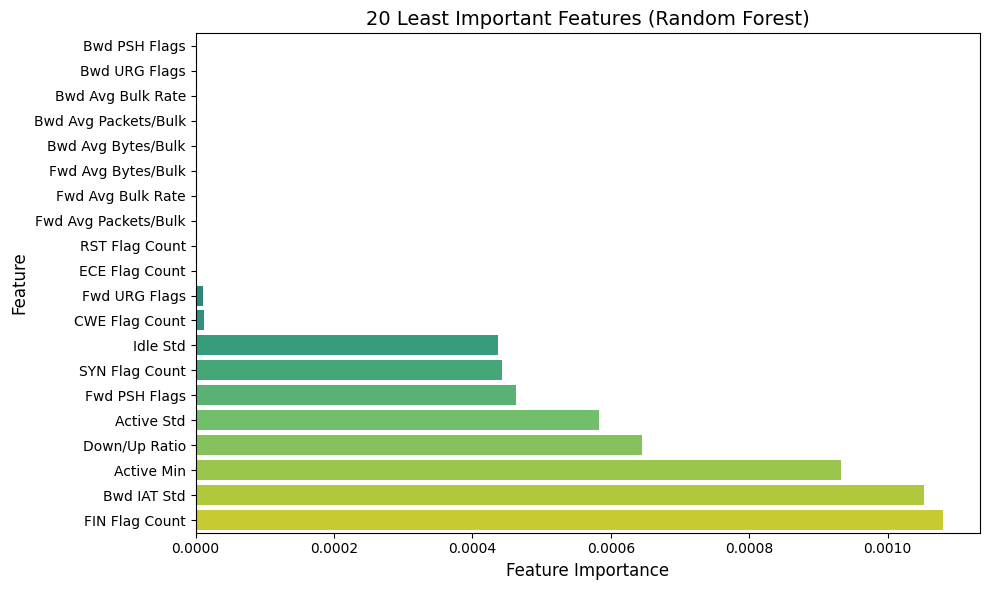

In [ ]:

# Plot the 20 least important features
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=least_important_20,
    palette="viridis"
)

plt.title("20 Least Important Features (Random Forest)", fontsize=14)
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()


In [23]:
# List of columns to drop (from your screenshot)
least_important_features = [
    "Bwd PSH Flags",
    "Fwd Avg Bulk Rate",
    "Bwd Avg Bytes/Bulk",
    "Bwd Avg Packets/Bulk",
    "Fwd Avg Packets/Bulk",
    "Fwd Avg Bytes/Bulk",
    "Bwd Avg Bulk Rate",
    "Bwd URG Flags",
    "RST Flag Count",
    "ECE Flag Count",
    "Fwd URG Flags",
    "CWE Flag Count",
    "Idle Std",
    "SYN Flag Count",
    "Fwd PSH Flags",
    "Active Std",
    "Down/Up Ratio",
    "Active Min",
    "Bwd IAT Std",
    "FIN Flag Count"
]

# Drop the columns safely (ignore if not found)
data = data.drop(columns=least_important_features, errors='ignore')

print("Remaining columns:", data.columns)

Remaining columns: Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'PSH Flag Count', 'ACK Flag Count',
       'URG Flag Count', 'Average Packet Size', 'Avg Fwd Segment Size',


In [24]:
len(data.columns)

59

C:\Users\willi\AppData\Local\Temp\ipykernel_18056\3915748367.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


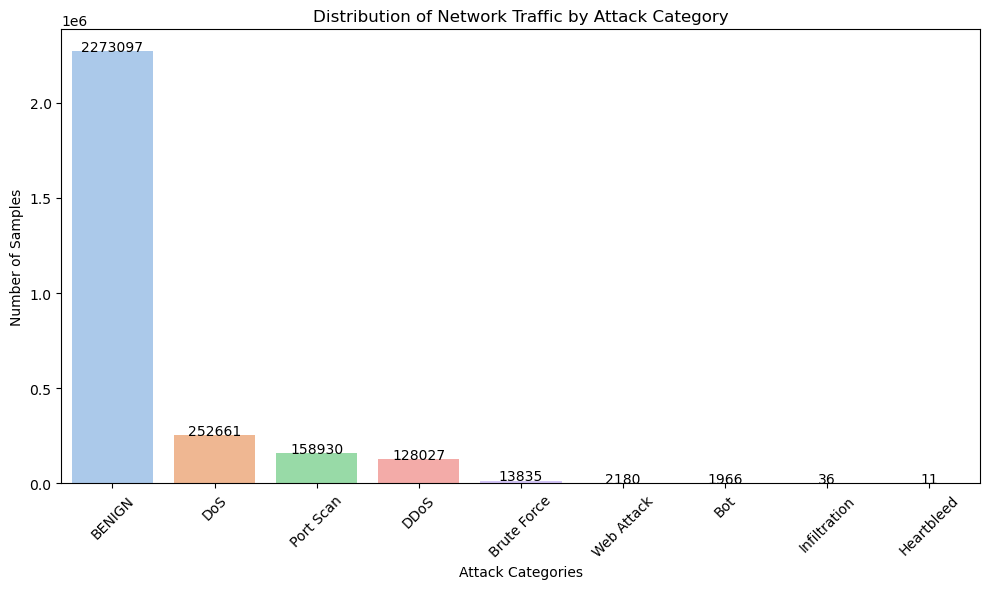

In [25]:
# Mapping dictionary
label_map = {
    0: "BENIGN",
    1: "Bot",
    2: "Brute Force",
    3: "DDoS",
    4: "DoS",
    5: "Heartbleed",
    6: "Infiltration",
    7: "Port Scan",
    8: "Web Attack"
}

# Replace numeric labels with names
data["label_name"] = data["label"].map(label_map)

plt.figure(figsize=(10, 6))
ax = sns.countplot(
    x="label_name",
    data=data,
    palette="pastel",
    order=data["label_name"].value_counts().index
)

plt.title("Distribution of Network Traffic by Attack Category")
plt.xlabel("Attack Categories")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)

# Annotate bars with counts
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.0f}',
        (p.get_x() + p.get_width() / 2, p.get_height() + 1000),
        ha='center'
    )

# Add a legend if you want to keep color reference
# plt.legend(title="Attack Type", loc="upper right")
plt.tight_layout()
plt.show()


In [26]:
data['label'].value_counts()

label
0    2273097
4     252661
7     158930
3     128027
2      13835
8       2180
1       1966
6         36
5         11
Name: count, dtype: int64

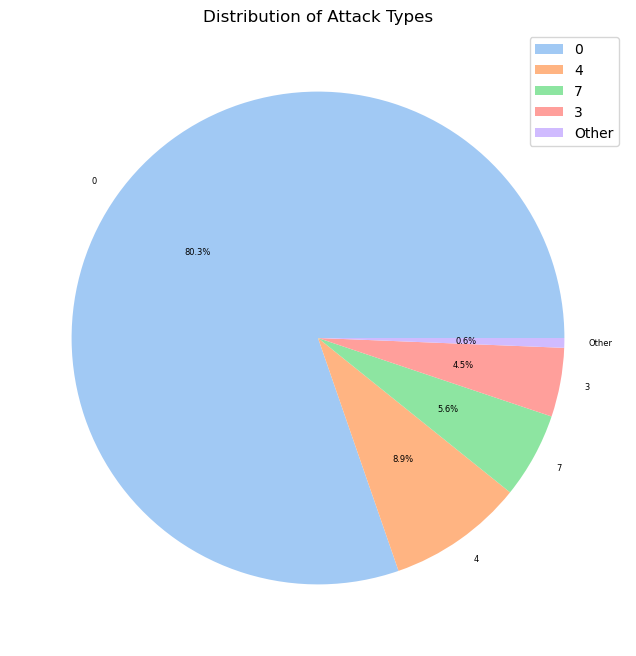

In [27]:
attack_counts = data['label'].value_counts()
threshold = 0.005
percentages = attack_counts / attack_counts.sum()
small_slices = percentages[percentages < threshold].index.tolist()
attack_counts['Other'] = attack_counts[small_slices].sum()
attack_counts.drop(small_slices, inplace = True)

sns.set_palette('pastel')
plt.figure(figsize = (8, 8))
plt.pie(attack_counts.values, labels = attack_counts.index, autopct = '%1.1f%%', textprops={'fontsize': 6})
plt.title('Distribution of Attack Types')
plt.legend(attack_counts.index, loc = 'best')
plt.show()

In [28]:
class_counts = data['label'].value_counts()
selected_classes = class_counts[class_counts > 1950]
class_names = selected_classes.index
selected = data[data['label'].isin(class_names)]

dfs = []
for name in class_names:
  df = selected[selected['label'] == name]
  if len(df) > 2500:
    df = df.sample(n = 10000, random_state = 0)

  dfs.append(df)

df = pd.concat(dfs, ignore_index = True)
df['label'].value_counts()

label
0    10000
4    10000
7    10000
3    10000
2    10000
8     2180
1     1966
Name: count, dtype: int64

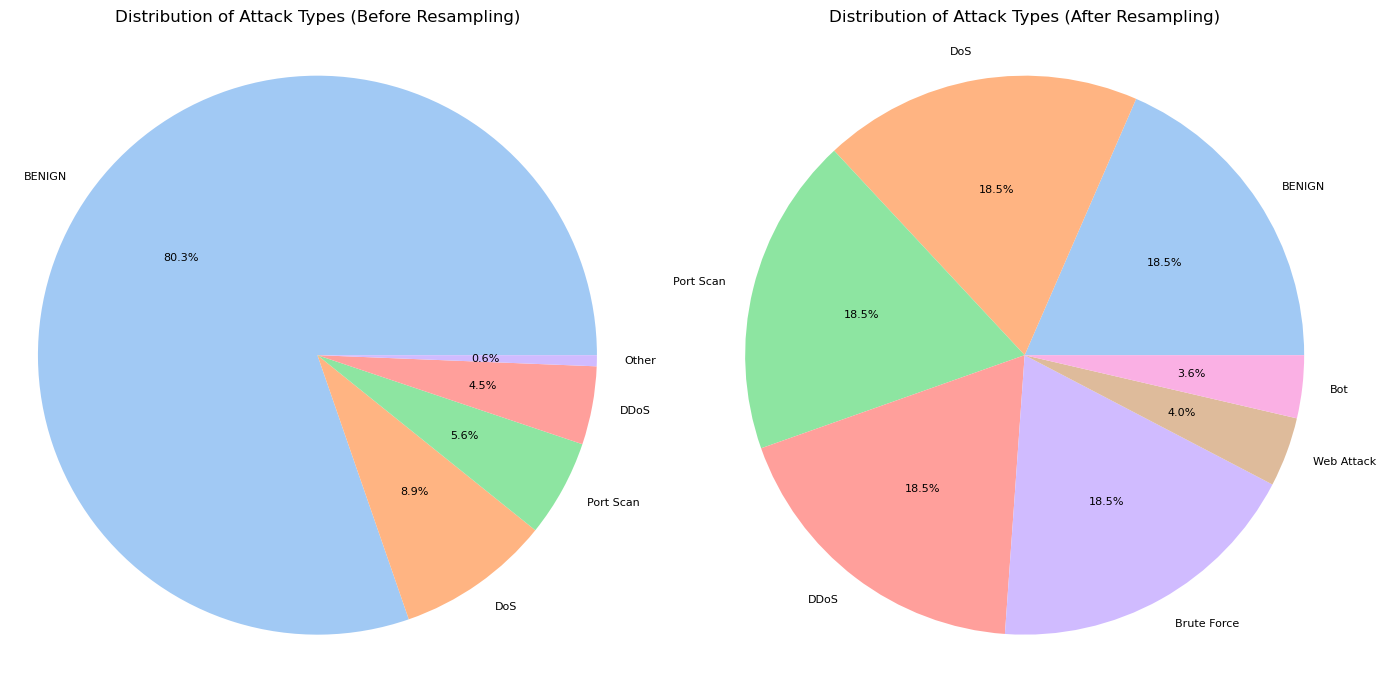

In [29]:
# 1) Map numeric labels to names
label_map = {
    0: "BENIGN",
    1: "Bot",
    2: "Brute Force",
    3: "DDoS",
    4: "DoS",
    5: "Heartbleed",
    6: "Infiltration",
    7: "Port Scan",
    8: "Web Attack"
}

def grouped_counts(frame, label_col="label", label_map=None, threshold=0.005):
    """Return counts with small categories merged into 'Other'."""
    counts = frame[label_col].value_counts()

    # Map numeric codes to names (leave as-is if already strings/unmapped)
    if label_map is not None:
        counts.index = counts.index.map(lambda x: label_map.get(x, x))

    # Group small slices
    percentages = counts / counts.sum()
    small = percentages[percentages < threshold].index
    counts_grouped = counts.copy()
    if len(small) > 0:
        counts_grouped.loc["Other"] = counts_grouped.loc[small].sum()
        counts_grouped = counts_grouped.drop(index=small)

    # Sort for consistent legend order
    return counts_grouped.sort_values(ascending=False)

# === params ===
threshold = 0.005  # 0.5% cutoff for "Other"

# 2) compute grouped counts for both dataframes
before_counts = grouped_counts(data, label_col="label", label_map=label_map, threshold=threshold)
after_counts  = grouped_counts(df,   label_col="label", label_map=label_map, threshold=threshold)

# 3) plot side-by-side
sns.set_palette("pastel")
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].pie(before_counts.values,
            labels=before_counts.index,
            autopct="%1.1f%%",
            textprops={"fontsize":8})
axes[0].set_title("Distribution of Attack Types (Before Resampling)")
axes[0].axis("equal")

axes[1].pie(after_counts.values,
            labels=after_counts.index,
            autopct="%1.1f%%",
            textprops={"fontsize":8})
axes[1].set_title("Distribution of Attack Types (After Resampling)")
axes[1].axis("equal")

plt.tight_layout()
plt.show()


In [30]:
# --- Config ---
label_col = "label"   # your encoded label column (integers from LabelEncoder)
output_dir = "federated_partitions"
random_state = 123
batch_rows = 10_000   # rows per write batch; tune this down if you still hit MemoryError


In [33]:
exclusive_map = {
    "Region1": 0,   # e.g., all rows with label 0 go ONLY to Region1
    "Region2": 1,   # label 1 -> ONLY Region2
    "Region3": 2,   # label 2 -> ONLY Region3
}
regions = list(exclusive_map.keys())

In [31]:
# ---------- 1) Shuffle by index (no DataFrame copy) ----------
rng = np.random.RandomState(random_state)
all_idx = data.index.to_numpy()
shuffled_idx = all_idx.copy()
rng.shuffle(shuffled_idx)

In [34]:
# ---------- 2) Separate indices for exclusive vs remaining ----------
labels = data[label_col].to_numpy()  # view, not a copy of whole df
exclusive_values = set(exclusive_map.values())

is_exclusive_mask = np.isin(labels, list(exclusive_values))
excl_idx = shuffled_idx[is_exclusive_mask[shuffled_idx]]
rem_idx = shuffled_idx[~is_exclusive_mask[shuffled_idx]]

In [35]:
exclusive_pools = {}
for enc_val in exclusive_values:
    mask = (labels == enc_val)
    pool = shuffled_idx[mask[shuffled_idx]]  # indices of this exclusive label
    exclusive_pools[enc_val] = pool



In [36]:
region_idx = {r: [] for r in regions}

unique_labels = np.unique(labels[rem_idx])
for enc_label in unique_labels:
    grp_mask = (labels[rem_idx] == enc_label)
    grp_idx = rem_idx[grp_mask]
    rng.shuffle(grp_idx)
    splits = np.array_split(grp_idx, len(regions))  # near-equal splits
    for r, split in zip(regions, splits):
        if split.size:
            region_idx[r].append(split)

In [37]:
# Concatenate per-region index arrays
for r in regions:
    region_idx[r] = np.concatenate(region_idx[r]) if region_idx[r] else np.array([], dtype=all_idx.dtype)

In [38]:
# ---------- 4) Add back each exclusive label ONLY to its designated region ----------
for r in regions:
    enc_val = exclusive_map[r]
    add_idx = exclusive_pools.get(enc_val, np.array([], dtype=all_idx.dtype))
    if add_idx.size:
        region_idx[r] = np.concatenate([region_idx[r], add_idx])
    rng.shuffle(region_idx[r])  # final shuffle per region


In [40]:
# ---------- 5) Build DataFrames for each region ----------
region_dfs = {}

for r in regions:
    if region_idx[r].size > 0:
        region_dfs[r] = data.loc[region_idx[r]].copy()
    else:
        # empty DataFrame with same columns
        region_dfs[r] = pd.DataFrame(columns=data.columns)

# Example: access Region1's DataFrame
print(region_dfs["Region1"].head())

        Destination Port  Flow Duration  Total Fwd Packets  \
384890             54498             38                  1   
384890                53          49440                  4   
384890               443      117485606                 25   
231224                53          66093                  2   
231224                53          69499                  1   

        Total Backward Packets  Total Length of Fwd Packets  \
384890                       1                            0   
384890                       2                          136   
384890                      29                         1659   
231224                       2                           68   
231224                       1                           40   

        Total Length of Bwd Packets  Fwd Packet Length Max  \
384890                            0                      0   
384890                          100                     34   
384890                         8060                    422   


In [41]:
region1_df = region_dfs["Region1"]
region2_df = region_dfs["Region2"]
region3_df = region_dfs["Region3"]
region1_df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Max,Idle Mean,Idle Max,Idle Min,label,label_name
384890,54498,38,1,1,0,0,0,0,0.000000,0.000000,...,32832,0,32,0.0,0,0.0,0,0,0,BENIGN
384890,53,49440,4,2,136,100,34,34,34.000000,0.000000,...,-1,3,32,0.0,0,0.0,0,0,0,BENIGN
384890,443,117485606,25,29,1659,8060,422,0,66.360000,94.540944,...,377,24,20,275976.0,318137,58300000.0,58800000,57900000,0,BENIGN
231224,53,66093,2,2,68,182,34,34,34.000000,0.000000,...,-1,1,20,0.0,0,0.0,0,0,0,BENIGN
231224,53,69499,1,1,40,266,40,40,40.000000,0.000000,...,-1,0,32,0.0,0,0.0,0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10517,443,116994584,15,14,1037,5250,372,0,69.133333,103.069925,...,360,14,20,141855.5,190230,58300000.0,58300000,58300000,0,BENIGN
10517,53,198,2,2,150,406,75,75,75.000000,0.000000,...,-1,1,20,0.0,0,0.0,0,0,0,BENIGN
10517,123,69083938,2,2,96,96,48,48,48.000000,0.000000,...,-1,1,20,85127.0,85127,68900000.0,68900000,68900000,0,BENIGN
10517,443,10204036,15,16,8607,12398,2807,0,573.800000,1130.070744,...,96,5,32,243000.0,243000,9959978.0,9959978,9959978,0,BENIGN


In [44]:
region1_df.to_csv("./federated_partitions/Region1.csv", index=False)   # save CSV without the index
region2_df.to_csv("./federated_partitions/Region2.csv", index=False)   # save CSV without the index
region3_df.to_csv("./federated_partitions/Region3.csv", index=False)   # save CSV without the index

In [ ]:
# from imblearn.over_sampling import SMOTE

# X = data.drop('label', axis=1)
# y = data['label']

# smote = SMOTE(sampling_strategy='auto', random_state=0)
# X_upsampled, y_upsampled = smote.fit_resample(X, y)

# blnc_data = pd.DataFrame(X_upsampled)
# blnc_data['label'] = y_upsampled
# blnc_data = blnc_data.sample(frac=1)

# blnc_data['label'].value_counts()

5    193748
4    193748
1    193748
7    193748
2    193748
3    193748
0    193748
6    193748
Name: label, dtype: int64